# Testing Schematic Loader Classes

This notebook tests the new SchematicLoader, VoxelProcessor, SchematicDataset, and SchematicViewer classes.

## 1. Test SchematicLoader

In [1]:
from pathlib import Path
import sys

# Add src to path
sys.path.insert(0, str(Path('../src').resolve()))

from minecraft_voxel_flow.loaders import SchematicLoader

# Initialize loader
loader = SchematicLoader()
print("✅ SchematicLoader initialized")
print(f"Supported formats: {loader.SUPPORTED_FORMATS}")

INFO - PyMCTranslate Version 348


✅ SchematicLoader initialized
Supported formats: ['.schematic', '.schem', '.litematic']


In [2]:
# Load a test schematic
test_file = Path("../data/schematics/10234.schematic")

print(f"Loading: {test_file.name}")
voxel_array, palette_reverse, palette = loader.load(test_file)

print(f"\n✅ Loaded successfully")
print(f"Shape: {voxel_array.shape}")
print(f"Unique blocks: {len(palette_reverse)}")
print(f"Memory: {voxel_array.nbytes / (1024**2):.2f} MB")

INFO - Loading level ../data/schematics/10234.schematic


Loading: 10234.schematic

✅ Loaded successfully
Shape: (13, 26, 37)
Unique blocks: 32
Memory: 0.05 MB


In [3]:
# Get statistics
stats = loader.get_statistics(voxel_array, palette_reverse)

print("Statistics:")
print(f"  Total blocks: {stats['total_blocks']:,}")
print(f"  Unique blocks: {stats['unique_blocks']}")
print(f"  Air blocks: {stats['air_blocks']:,} ({stats['air_percentage']:.1f}%)")
print(f"  Solid blocks: {stats['solid_blocks']:,}")
print(f"\nTop 5 blocks:")
for block in stats['top_blocks'][:5]:
    print(f"  - {block['block_name']}: {block['count']:,} ({block['percentage']:.1f}%)")

Statistics:
  Total blocks: 12,506
  Unique blocks: 32
  Air blocks: 9,359 (74.8%)
  Solid blocks: 3,147

Top 5 blocks:
  - universal_minecraft:air: 9,329 (74.6%)
  - universal_minecraft:water[falling="false",flowing="false",level="0"]: 1,726 (13.8%)
  - universal_minecraft:planks[material="dark_oak"]: 906 (7.2%)
  - universal_minecraft:log[axis="z",material="spruce",stripped="false"]: 134 (1.1%)
  - universal_minecraft:log[axis="y",material="spruce",stripped="false"]: 112 (0.9%)


In [4]:
# Test save/load processed
output_path = Path("../data/processed_schematics/test_loader.npz")

loader.save_processed(voxel_array, palette_reverse, output_path, test_file)
print(f"✅ Saved to: {output_path}")

# Load it back
loaded_voxels, loaded_palette = loader.load_processed(output_path)
print(f"✅ Loaded from: {output_path}")
print(f"Arrays match: {(voxel_array == loaded_voxels).all()}")

✅ Saved to: ../data/processed_schematics/test_loader.npz
✅ Loaded from: ../data/processed_schematics/test_loader.npz
Arrays match: True


## 2. Test VoxelProcessor

In [5]:
from minecraft_voxel_flow.processors import VoxelProcessor

processor = VoxelProcessor()
print("✅ VoxelProcessor initialized")

✅ VoxelProcessor initialized


In [6]:
# Test remove air
print(f"Original shape: {voxel_array.shape}")

cropped, offset = processor.remove_air(voxel_array, palette_reverse)

print(f"Cropped shape: {cropped.shape}")
print(f"Offset: {offset}")
print(f"Volume reduction: {voxel_array.size / cropped.size:.2f}x")

Original shape: (13, 26, 37)
Cropped shape: (13, 26, 37)
Offset: (0, 0, 0)
Volume reduction: 1.00x


In [7]:
# Test normalization to 64^3
target_size = (64, 64, 64)

normalized = processor.normalize_size(
    voxel_array,
    target_size,
    palette_reverse,
    remove_air_first=True
)

print(f"Normalized shape: {normalized.shape}")
print(f"Target shape: {target_size}")
print(f"Match: {normalized.shape == target_size}")

Normalized shape: (64, 64, 64)
Target shape: (64, 64, 64)
Match: True


In [8]:
# Test rotation
rotated = processor.rotate_90(voxel_array, axis=1, k=1)

print(f"Original shape: {voxel_array.shape}")
print(f"Rotated shape: {rotated.shape}")
print("✅ Rotation successful")

Original shape: (13, 26, 37)
Rotated shape: (37, 26, 13)
✅ Rotation successful


In [9]:
# Test block simplification
print(f"Original unique blocks: {len(palette_reverse)}")

simplified, new_palette = processor.simplify_palette(voxel_array, palette_reverse)

print(f"Simplified unique blocks: {len(new_palette)}")
print(f"Reduction: {len(palette_reverse) - len(new_palette)} blocks")
print(f"\nExample simplified blocks:")
for i, (block_id, block_name) in enumerate(list(new_palette.items())[:5]):
    print(f"  {block_id}: {block_name}")

Original unique blocks: 32
Simplified unique blocks: 12
Reduction: 20 blocks

Example simplified blocks:
  0: universal_minecraft:air
  1: universal_minecraft:water
  2: universal_minecraft:planks
  3: universal_minecraft:log
  4: universal_minecraft:fence


In [10]:
# Test patching
patches = processor.split_into_patches(normalized, patch_size=16, stride=16)

print(f"Normalized shape: {normalized.shape}")
print(f"Patch size: 16x16x16")
print(f"Number of patches: {len(patches)}")
print(f"Each patch shape: {patches[0].shape}")

Normalized shape: (64, 64, 64)
Patch size: 16x16x16
Number of patches: 64
Each patch shape: (16, 16, 16)


## 3. Test SchematicViewer

In [11]:
from minecraft_voxel_flow.visualization import SchematicViewer

viewer = SchematicViewer(backend='matplotlib')
print("✅ SchematicViewer initialized")

✅ SchematicViewer initialized


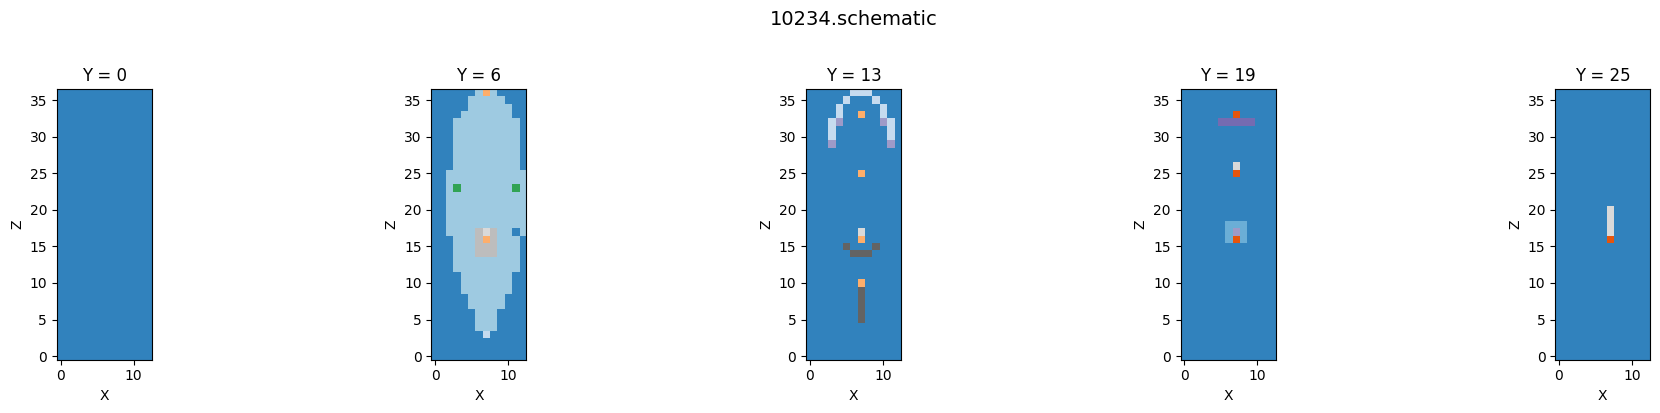

In [12]:
# View horizontal slices
viewer.view_slices(
    voxel_array,
    palette_reverse,
    num_slices=5,
    direction='horizontal',
    title=test_file.name
)

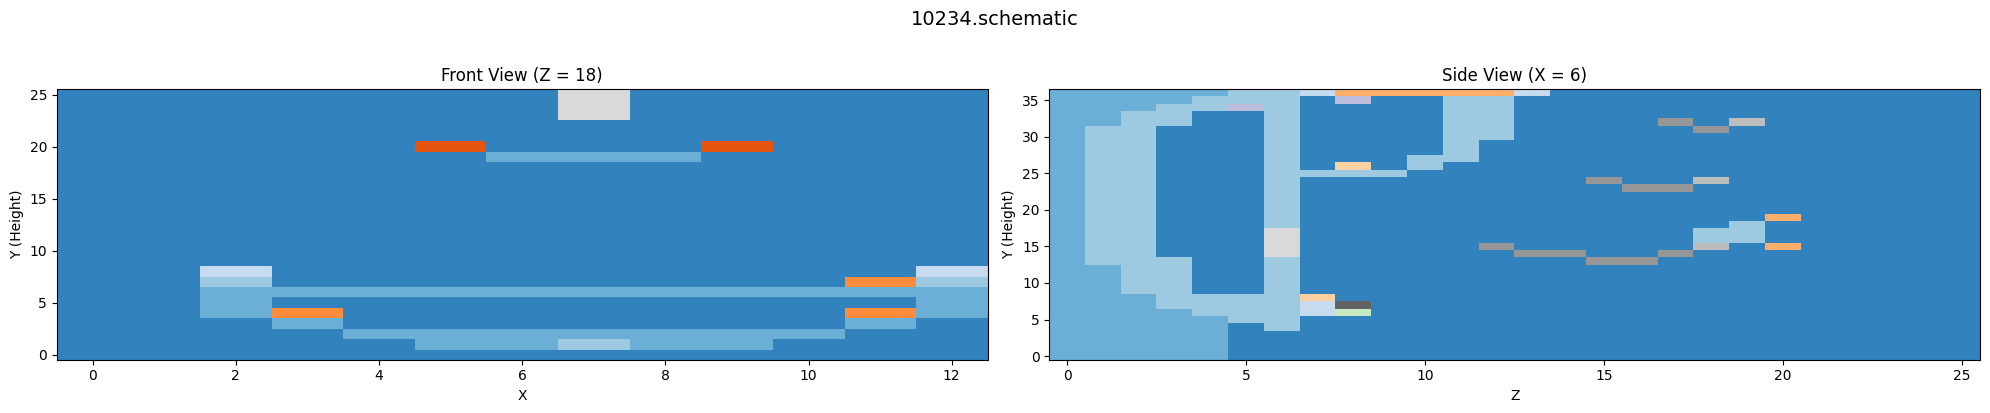

In [13]:
# View vertical slices
viewer.view_slices(
    voxel_array,
    palette_reverse,
    direction='vertical',
    title=test_file.name
)

In [14]:
# View 3D (requires plotly)
viewer.view_3d(
    voxel_array,
    palette_reverse,
    max_blocks=5000,
    title=test_file.name
)

Non-air blocks: 3,147


## 4. Test SchematicDataset

In [15]:
from minecraft_voxel_flow.data.schematic_dataset import SchematicDataset
from torch.utils.data import DataLoader

# Create dataset
dataset = SchematicDataset(
    schematic_dir="../data/schematics",
    target_size=(64, 64, 64),
    simplify_blocks=True,
    cache=False
)

print(f"✅ Dataset created")
print(f"Number of schematics: {len(dataset)}")
print(f"\nDataset stats:")
stats = dataset.get_statistics()
for key, value in stats.items():
    print(f"  {key}: {value}")

✅ Dataset created
Number of schematics: 10665

Dataset stats:
  num_schematics: 10665
  file_format: raw schematics
  target_size: (64, 64, 64)
  cache_enabled: False
  cached_items: 0


In [16]:
# Test loading a sample
sample = dataset[0]

print(f"Sample tensor shape: {sample.shape}")
print(f"Sample dtype: {sample.dtype}")
print(f"Sample device: {sample.device}")

INFO - Loading level ../data/schematics/10001.schematic


Sample tensor shape: torch.Size([1, 64, 64, 64])
Sample dtype: torch.float32
Sample device: cpu


In [17]:
# Test with DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0
)

# Get a batch
batch = next(iter(dataloader))

print(f"Batch shape: {batch.shape}")
print(f"Expected: (batch_size, channels, width, height, depth)")
print(f"Actual: (4, 1, 64, 64, 64)")

INFO - Loading level ../data/schematics/7005.schematic
INFO - Loading level ../data/schematics/7722.schematic
INFO - Loading level ../data/schematics/9104.schematic
INFO - Loading level ../data/schematics/4253.schematic


Batch shape: torch.Size([4, 1, 64, 64, 64])
Expected: (batch_size, channels, width, height, depth)
Actual: (4, 1, 64, 64, 64)


In [18]:
# Test get_item_with_metadata
metadata = dataset.get_item_with_metadata(0)

print("Metadata keys:", list(metadata.keys()))
print(f"\nFilename: {metadata['filename']}")
print(f"Original shape: {metadata['shape']}")
print(f"Normalized shape: {metadata['normalized_shape']}")
print(f"Unique blocks in palette: {len(metadata['palette'])}")

INFO - Loading level ../data/schematics/10001.schematic


Metadata keys: ['voxels', 'palette', 'filename', 'shape', 'normalized_shape']

Filename: 10001.schematic
Original shape: (94, 24, 96)
Normalized shape: (64, 64, 64)
Unique blocks in palette: 37


## 5. End-to-End Example

INFO - Loading level ../data/schematics/7704.schematic


END-TO-END WORKFLOW

1. Loading schematic...
   ✅ Loaded: (77, 35, 61)

2. Processing...
   ✅ Cropped: (77, 35, 61) -> (77, 35, 61)
   ✅ Normalized to: (64, 64, 64)
   ✅ Simplified: 251 -> 90 blocks

3. Visualizing...


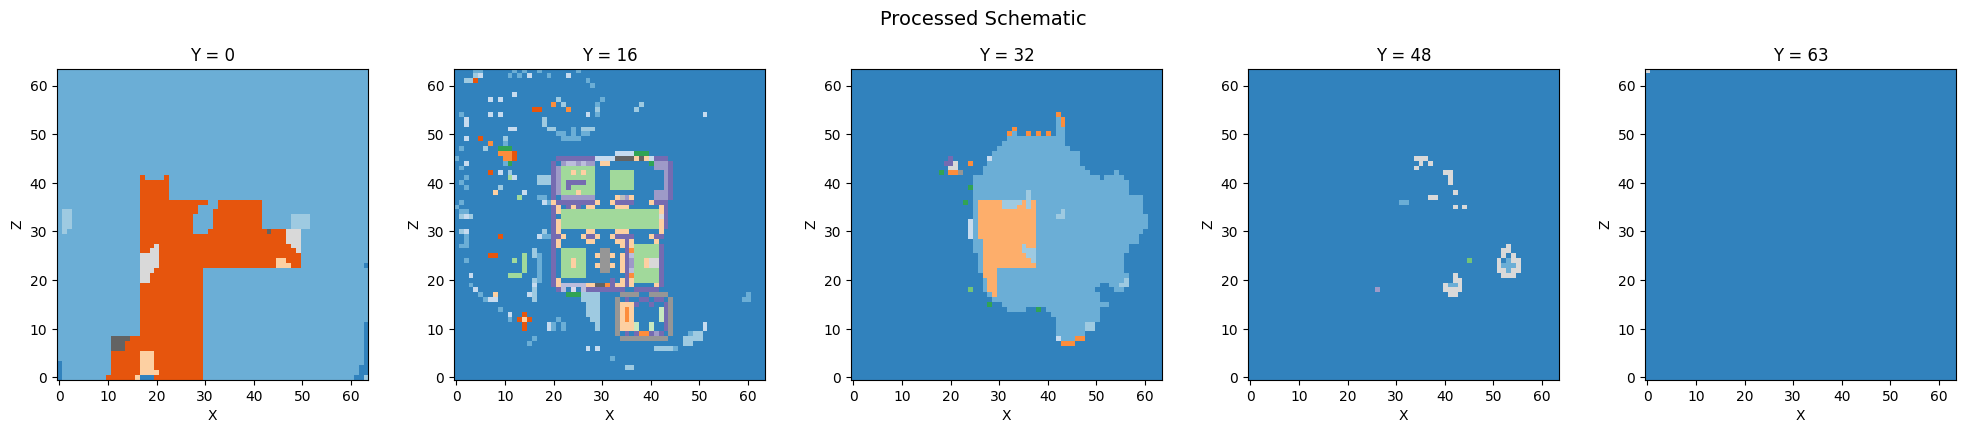

   ✅ Visualization complete

✅ WORKFLOW COMPLETE


In [19]:
# Complete workflow: Load -> Process -> Visualize

print("=" * 60)
print("END-TO-END WORKFLOW")
print("=" * 60)

# 1. Load schematic
print("\n1. Loading schematic...")
loader = SchematicLoader()
voxels, palette_rev, palette = loader.load("../data/schematics/7704.schematic")
print(f"   ✅ Loaded: {voxels.shape}")

# 2. Process
print("\n2. Processing...")
processor = VoxelProcessor()

# Remove air
voxels_cropped, _ = processor.remove_air(voxels, palette_rev)
print(f"   ✅ Cropped: {voxels.shape} -> {voxels_cropped.shape}")

# Normalize to 64^3
voxels_norm = processor.normalize_size(voxels, (64, 64, 64), palette_rev)
print(f"   ✅ Normalized to: {voxels_norm.shape}")

# Simplify blocks
voxels_simple, palette_simple = processor.simplify_palette(voxels_norm, palette_rev)
print(f"   ✅ Simplified: {len(palette_rev)} -> {len(palette_simple)} blocks")

# 3. Visualize
print("\n3. Visualizing...")
viewer = SchematicViewer()
viewer.view_slices(voxels_simple, palette_simple, num_slices=5, title="Processed Schematic")
print("   ✅ Visualization complete")

print("\n" + "=" * 60)
print("✅ WORKFLOW COMPLETE")
print("=" * 60)

## Summary

All core modules tested successfully:

1. ✅ **SchematicLoader** - Load/save schematics, get statistics
2. ✅ **VoxelProcessor** - Remove air, normalize, rotate, simplify, patch
3. ✅ **SchematicViewer** - 2D slices, 3D interactive plots
4. ✅ **SchematicDataset** - PyTorch dataset with DataLoader support

Ready for ML pipeline integration!